In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def cv2_imshow(img):
    h = plt.imshow(img)
    return h

print('Confirming Jupyter notebook running')


Confirming Jupyter notebook running


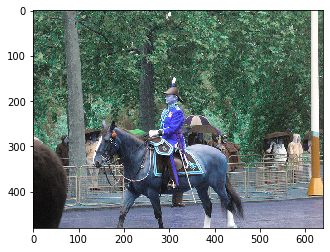

In [8]:
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)


In [9]:
DETECTRON_MODEL_ZOO = os.path.expanduser('~/data/models/detectron_model_zoo')
CITYSCAPES_MODEL_URL = 'Cityscapes/mask_rcnn_R_50_FPN/142423278/model_final_af9cf5.pkl'
CITYSCAPES_CONFIG_FILE = 'Cityscapes/mask_rcnn_R_50_FPN.yaml'

model_rel_path, config_file = CITYSCAPES_MODEL_URL, CITYSCAPES_CONFIG_FILE


assert os.path.isdir(DETECTRON_MODEL_ZOO)
import subprocess

def download_detectron_model_to_local_zoo(relurl):
    if relurl.startswith('detectron2://'):
        relurl.replace('detectron2://', '', 1)
    if relurl.startswith('https://dl.fbaipublicfiles.com/'):
        relurl.replace('https://dl.fbaipublicfiles.com/', '', 1)
    url = 'https://dl.fbaipublicfiles.com/detectron2/' + relurl
    outpath = os.path.join(DETECTRON_MODEL_ZOO, relurl)
    outdir = os.path.dirname(outpath)
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    assert os.path.isdir(outdir)
    if os.path.exists(outpath):
        return outpath
    try:
        subprocess.check_output(['wget', url, '-O', outpath])
    except CalledProcessError:
        print(stderr)
        raise
    assert os.path.exists(outpath)
    return outpath


DETECTRON_REPO = './detectron2_repo'
cfg = get_cfg()
cfg.merge_from_file(f"{DETECTRON_REPO}/configs/{CITYSCAPES_CONFIG_FILE}")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the following shorthand
local_path = download_detectron_model_to_local_zoo(model_rel_path)
cfg.MODEL.WEIGHTS = local_path
predictor = DefaultPredictor(cfg)


WARNING [01/23 11:40:56 d2.config.compat]: Config './detectron2_repo/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [10]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs = predictor(im)
outputs["instances"].pred_classes
outputs["instances"].pred_boxes



Boxes(tensor([[529.3043, 282.0288, 560.4156, 320.2418],
        [ 49.6841, 274.8876,  78.8202, 345.6454],
        [403.6128, 272.6875, 458.0619, 335.2545],
        [385.8757, 272.7097, 413.8625, 304.8044],
        [506.4155, 284.1458, 532.6352, 328.4485],
        [560.6390, 271.9739, 596.3575, 323.8983],
        [  3.6035, 277.3786,  75.1362, 474.6302],
        [113.7188, 266.4980, 142.9203, 350.4475]], device='cuda:0'))

cityscapes_fine_instance_seg_train


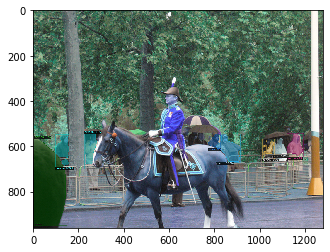

In [16]:
# We can use `Visualizer` to draw the predictions on the image.
print(cfg.DATASETS.TRAIN[0])
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2.0)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [4]:
## BALLOONS
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(f"{DETECTRON_REPO}/configs/{config_file}")
cfg.DATASETS.TRAIN = ("cityscapes_fine_instance_seg_train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [01/21 16:27:09 d2.config.compat]: Config './detectron2_repo/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[01/21 16:27:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2

AssertionError: No images found in datasets/cityscapes/leftImg8bit/train

In [78]:
## BALLOONS
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output
# Run on localhost:
# jptt 6006 6006 kalman 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25274), started 0:11:49 ago. (Use '!kill 25274' to kill it.)

WARNING [10/27 17:44:08 d2.config.compat]: Config './detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


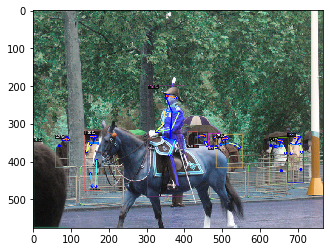

In [6]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(f"{DETECTRON_REPO}/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

WARNING [10/27 17:45:27 d2.config.compat]: Config './detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


model_final_cafdb1.pkl: 261MB [00:12, 21.1MB/s]                              


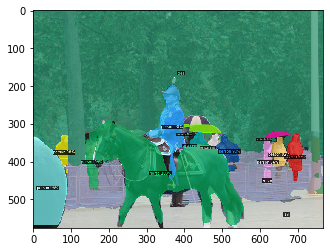

In [7]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.WEIGHTS = "detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl"
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])


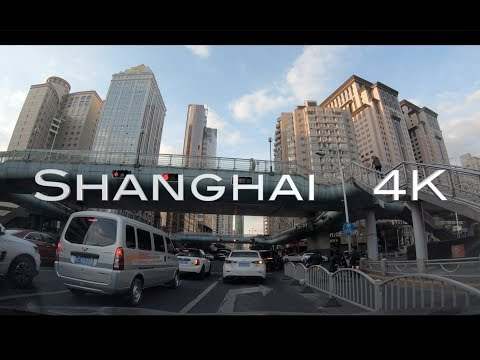

In [8]:
## Video-based panoptic segmentation
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [9]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

     |████████████████████████████████| 1.8MB 3.2MB/s eta 0:00:01
Uninstalling opencv-python-4.1.0.25:
  Successfully uninstalled opencv-python-4.1.0.25
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
[youtube] ll8TgCZ0plk: Downloading webpage
[youtube] ll8TgCZ0plk: Downloading video info webpage
[download] Destination: video.mp4
[download] 100% of 404.40MiB in 00:1199MiB/s ETA 00:002nown ETA
ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avre

# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
!cd detectron2_repo && python demo/demo.py --config-file configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input ../video-clip.mp4 --confidence-threshold 0.6 --output ../video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
    

## Note the previous thing broke :(  -- doesn't like the video-output.mkv thing.